In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import PIL
import pickle

In [2]:
print(tf.__version__)
print(tf.test.is_gpu_available())
print(tf.config.list_physical_devices('GPU'))

2.3.1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# TensorFlow 2.1, Keras - workaround:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [4]:
with open("monet_image_file_names.pickle", "rb") as f:
    monet_image_file_names = pickle.load(f)
with open("monet_images.pickle", "rb") as f:
    monet_images = pickle.load(f)

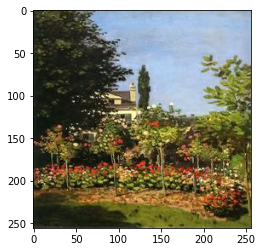

In [5]:
plt.imshow(monet_images[0])

## Generator

In [67]:
GZ1_L = tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=[5, 5], use_bias=False, padding="same")
GB1_L = tf.keras.layers.BatchNormalization(axis=3)
GA1_L = tf.keras.layers.LeakyReLU(alpha=0.1)
GU1_L = tf.keras.layers.UpSampling2D(size=(2, 2))

GZ2_L = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=[5, 5], use_bias=False, padding="same")
GB2_L = tf.keras.layers.BatchNormalization(axis=3)
GA2_L = tf.keras.layers.LeakyReLU(alpha=0.1)
GU2_L = tf.keras.layers.UpSampling2D(size=(2, 2))

GZ3_L = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=[5, 5], use_bias=False, padding="same")
GB3_L = tf.keras.layers.BatchNormalization(axis=3)
GA3_L = tf.keras.layers.LeakyReLU(alpha=0.1)
GU3_L = tf.keras.layers.UpSampling2D(size=(2, 2))

GZ4_L = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=[5, 5], use_bias=False, padding="same")
GB4_L = tf.keras.layers.BatchNormalization(axis=3)
GA4_L = tf.keras.layers.LeakyReLU(alpha=0.1)
GU4_L = tf.keras.layers.UpSampling2D(size=(2, 2))

GZ5_L = tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=[5, 5], use_bias=False, padding="same")
GB5_L = tf.keras.layers.BatchNormalization(axis=3)
GA5_L = tf.keras.layers.LeakyReLU(alpha=0.1)
GU5_L = tf.keras.layers.UpSampling2D(size=(2, 2))

GZ6_L = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=[5, 5], use_bias=False, padding="same")
GB6_L = tf.keras.layers.BatchNormalization(axis=3)
GA6_L = tf.keras.layers.Activation('sigmoid')

def buildup_generator(GX):
    GZ1 = GZ1_L(GX)
    GB1 = GB1_L(GZ1)
    GA1 = GA1_L(GB1)
    GU1 = GU1_L(GA1)

    GZ2 = GZ2_L(GU1)
    GB2 = GB2_L(GZ2)
    GA2 = GA2_L(GB2)
    GU2 = GU2_L(GA2)

    GZ3 = GZ3_L(GU2)
    GB3 = GB3_L(GZ3)
    GA3 = GA3_L(GB3)
    GU3 = GU3_L(GA3)

    GZ4 = GZ4_L(GU3)
    GB4 = GB4_L(GZ4)
    GA4 = GA4_L(GB4)
    GU4 = GU4_L(GA4)

    GZ5 = GZ5_L(GU4)
    GB5 = GB5_L(GZ5)
    GA5 = GA5_L(GB5)
    GU5 = GU5_L(GA5)

    GZ6 = GZ6_L(GU5)
    GB6 = GB6_L(GZ6)
    GY = GA6_L(GB6)
    return GY

In [68]:
GX = tf.keras.layers.Input(shape=[8, 8, 1], dtype=tf.float32)
GY = buildup_generator(GX)

generator = tf.keras.models.Model(inputs=GX, outputs=GY)
generator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, clipvalue=1.0), loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])
generator.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 8, 8, 1)]         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 8)           200       
_________________________________________________________________
batch_normalization_11 (Batc (None, 8, 8, 8)           32        
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 8, 8, 8)           0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 16, 16, 16)        3200      
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 16, 16)      

In [180]:
generator.save('generator.h5')

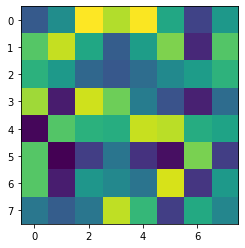

In [185]:
noiseimg = np.random.rand(1, 8, 8, 1)
plt.imshow(np.reshape(noiseimg, (8, 8, 1)))

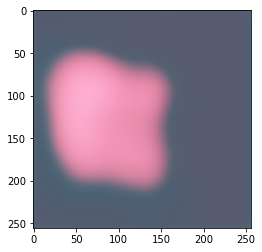

In [186]:
plt.imshow(generator.predict(noiseimg)[0])

## Discriminator

In [70]:
DZ1_L = tf.keras.layers.Conv2D(filters=32, kernel_size=[5, 5], use_bias=False, padding="same")
DB1_L = tf.keras.layers.BatchNormalization(axis=3)
DA1_L = tf.keras.layers.LeakyReLU(alpha=0.1)
DU1_L = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")

DZ2_L = tf.keras.layers.Conv2D(filters=64, kernel_size=[5, 5], use_bias=False, padding="same")
DB2_L = tf.keras.layers.BatchNormalization(axis=3)
DA2_L = tf.keras.layers.LeakyReLU(alpha=0.1)
DU2_L = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")

DZ3_L = tf.keras.layers.Conv2D(filters=64, kernel_size=[5, 5], use_bias=False, padding="same")
DB3_L = tf.keras.layers.BatchNormalization(axis=3)
DA3_L = tf.keras.layers.LeakyReLU(alpha=0.1)
DU3_L = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")

DZ4_L = tf.keras.layers.Conv2D(filters=32, kernel_size=[5, 5], use_bias=False, padding="same")
DB4_L = tf.keras.layers.BatchNormalization(axis=3)
DA4_L = tf.keras.layers.LeakyReLU(alpha=0.1)
DU4_L = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")

DZ5_L = tf.keras.layers.Conv2D(filters=8, kernel_size=[5, 5], use_bias=False, padding="same")
DB5_L = tf.keras.layers.BatchNormalization(axis=3)
DA5_L = tf.keras.layers.LeakyReLU(alpha=0.1)
DU5_L = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")

DF6_L = tf.keras.layers.Flatten()
DZ6_L = tf.keras.layers.Dense(units=16, use_bias=False)
DB6_L = tf.keras.layers.BatchNormalization()
DA6_L = tf.keras.layers.LeakyReLU(alpha=0.1)

DZ7_L = tf.keras.layers.Dense(units=1, use_bias=True)

DY_L = tf.keras.layers.Activation('sigmoid')

def buildup_dicriminator(DX):
    DZ1 = DZ1_L(DX)
    DB1 = DB1_L(DZ1)
    DA1 = DA1_L(DB1)
    DU1 = DU1_L(DA1)

    DZ2 = DZ2_L(DU1)
    DB2 = DB2_L(DZ2)
    DA2 = DA2_L(DB2)
    DU2 = DU2_L(DA2)

    DZ3 = DZ3_L(DU2)
    DB3 = DB3_L(DZ3)
    DA3 = DA3_L(DB3)
    DU3 = DU3_L(DA3)

    DZ4 = DZ4_L(DU3)
    DB4 = DB4_L(DZ4)
    DA4 = DA4_L(DB4)
    DU4 = DU4_L(DA4)

    DZ5 = DZ5_L(DU4)
    DB5 = DB5_L(DZ5)
    DA5 = DA5_L(DB5)
    DU5 = DU5_L(DA5)

    DF6 = DF6_L(DU5)
    DZ6 = DZ6_L(DF6)
    DB6 = DB6_L(DZ6)
    DA6 = DA6_L(DB6)

    DZ7 = DZ7_L(DA6)

    DY = DY_L(DZ7)
    return DY

def set_discriminator(trainable):
    DZ1_L.trainable = trainable
    DB1_L.trainable = trainable
    DZ2_L.trainable = trainable
    DB2_L.trainable = trainable
    DZ3_L.trainable = trainable
    DB3_L.trainable = trainable
    DZ4_L.trainable = trainable
    DB4_L.trainable = trainable
    DZ5_L.trainable = trainable
    DB5_L.trainable = trainable
    DZ6_L.trainable = trainable
    DB6_L.trainable = trainable
    DZ7_L.trainable = trainable    

In [71]:
DX = tf.keras.layers.Input(shape=[256, 256, 3], dtype=tf.float32)
DY = buildup_dicriminator(DX)

discriminator = tf.keras.models.Model(inputs=DX, outputs=DY)
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, clipvalue=1.0), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
discriminator.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 32)      2400      
_________________________________________________________________
batch_normalization_17 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 64)      51200     
_________________________________________________________________
batch_normalization_18 (Batc (None, 128, 128, 64)    

In [189]:
discriminator.predict(generator.predict(np.random.rand(10, 8, 8, 1)))

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [188]:
discriminator.predict(monet_images[np.random.randint(monet_images.shape[0], size=[10])])

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

## Learning data for discriminator

In [155]:
batch_semisize = 1000

In [156]:
monet_X = monet_images[np.random.randint(monet_images.shape[0], size=[batch_semisize]), :, :, :]
monet_Y = np.array([1] * batch_semisize)

In [157]:
generated_X = generator.predict(np.random.rand(batch_semisize, 8, 8, 1))
generated_Y = np.array([0] * batch_semisize)

In [158]:
perm = np.random.permutation(2 * batch_semisize)
batch_X = np.concatenate((monet_X, generated_X))[perm]
batch_Y = np.concatenate((monet_Y, generated_Y))[perm]

## Train Discriminator

In [159]:
set_discriminator(True)  # trainable
discriminator.fit(tf.convert_to_tensor(batch_X, dtype=tf.float32), tf.convert_to_tensor(batch_Y, dtype=tf.float32), epochs=1000)

Epoch 1/1000
63/63 [==============================] - 5s 81ms/step - loss: 0.6171 - accuracy: 0.9145
Epoch 2/1000
63/63 [==============================] - 5s 76ms/step - loss: 0.0064 - accuracy: 0.9985
Epoch 3/1000
63/63 [==============================] - 5s 77ms/step - loss: 0.0015 - accuracy: 0.9990
Epoch 4/1000
63/63 [==============================] - 5s 77ms/step - loss: 0.0014 - accuracy: 0.9995
Epoch 5/1000
63/63 [==============================] - 5s 77ms/step - loss: 8.9916e-04 - accuracy: 1.0000
Epoch 6/1000
63/63 [==============================] - 5s 78ms/step - loss: 3.8594e-04 - accuracy: 1.0000
Epoch 7/1000
63/63 [==============================] - 5s 78ms/step - loss: 2.8383e-04 - accuracy: 1.0000
Epoch 8/1000
63/63 [==============================] - 5s 77ms/step - loss: 9.3392e-05 - accuracy: 1.0000
Epoch 9/1000
63/63 [==============================] - 5s 78ms/step - loss: 4.8663e-04 - accuracy: 1.0000
Epoch 10/1000
63/63 [==============================] - 5s 78ms/step - l

63/63 [==============================] - 5s 77ms/step - loss: 3.0171e-06 - accuracy: 1.0000
Epoch 79/1000
63/63 [==============================] - 5s 77ms/step - loss: 3.2733e-06 - accuracy: 1.0000
Epoch 80/1000
63/63 [==============================] - 5s 77ms/step - loss: 1.7655e-06 - accuracy: 1.0000
Epoch 81/1000
63/63 [==============================] - 5s 78ms/step - loss: 8.3128e-06 - accuracy: 1.0000
Epoch 82/1000
63/63 [==============================] - 5s 79ms/step - loss: 6.5474e-06 - accuracy: 1.0000
Epoch 83/1000
63/63 [==============================] - 5s 78ms/step - loss: 4.6678e-06 - accuracy: 1.0000
Epoch 84/1000
63/63 [==============================] - 5s 78ms/step - loss: 4.7072e-06 - accuracy: 1.0000
Epoch 85/1000
63/63 [==============================] - 5s 77ms/step - loss: 2.1517e-06 - accuracy: 1.0000
Epoch 86/1000
63/63 [==============================] - 5s 77ms/step - loss: 2.3617e-06 - accuracy: 1.0000
Epoch 87/1000
63/63 [==============================] - 5s 77

63/63 [==============================] - 5s 78ms/step - loss: 1.8305e-06 - accuracy: 1.0000
Epoch 155/1000
63/63 [==============================] - 5s 77ms/step - loss: 3.3839e-07 - accuracy: 1.0000
Epoch 156/1000
63/63 [==============================] - 5s 77ms/step - loss: 2.2087e-07 - accuracy: 1.0000
Epoch 157/1000
63/63 [==============================] - 5s 77ms/step - loss: 2.2214e-07 - accuracy: 1.0000
Epoch 158/1000
63/63 [==============================] - 5s 77ms/step - loss: 1.5298e-07 - accuracy: 1.0000
Epoch 159/1000
63/63 [==============================] - 5s 77ms/step - loss: 1.3120e-07 - accuracy: 1.0000
Epoch 160/1000
63/63 [==============================] - 5s 77ms/step - loss: 1.0845e-07 - accuracy: 1.0000
Epoch 161/1000
63/63 [==============================] - 5s 77ms/step - loss: 1.5104e-07 - accuracy: 1.0000
Epoch 162/1000
63/63 [==============================] - 5s 77ms/step - loss: 3.5734e-07 - accuracy: 1.0000
Epoch 163/1000
63/63 [==============================

63/63 [==============================] - 5s 77ms/step - loss: 2.6115e-08 - accuracy: 1.0000
Epoch 231/1000
63/63 [==============================] - 5s 76ms/step - loss: 2.2620e-08 - accuracy: 1.0000
Epoch 232/1000
63/63 [==============================] - 5s 77ms/step - loss: 4.3826e-08 - accuracy: 1.0000
Epoch 233/1000
63/63 [==============================] - 5s 77ms/step - loss: 2.7680e-08 - accuracy: 1.0000
Epoch 234/1000
63/63 [==============================] - 5s 77ms/step - loss: 3.4394e-08 - accuracy: 1.0000
Epoch 235/1000
63/63 [==============================] - 5s 77ms/step - loss: 8.1842e-09 - accuracy: 1.0000
Epoch 236/1000
63/63 [==============================] - 5s 77ms/step - loss: 3.4239e-07 - accuracy: 1.0000
Epoch 237/1000
63/63 [==============================] - 5s 77ms/step - loss: 1.7564e-08 - accuracy: 1.0000
Epoch 238/1000
63/63 [==============================] - 5s 77ms/step - loss: 7.5065e-08 - accuracy: 1.0000
Epoch 239/1000
63/63 [==============================

63/63 [==============================] - 5s 77ms/step - loss: 5.7885e-06 - accuracy: 1.0000
Epoch 307/1000
63/63 [==============================] - 5s 77ms/step - loss: 0.0014 - accuracy: 0.9995
Epoch 308/1000
63/63 [==============================] - 5s 77ms/step - loss: 3.6507e-06 - accuracy: 1.0000
Epoch 309/1000
63/63 [==============================] - 5s 76ms/step - loss: 2.7776e-07 - accuracy: 1.0000
Epoch 310/1000
63/63 [==============================] - 5s 77ms/step - loss: 7.3313e-06 - accuracy: 1.0000
Epoch 311/1000
63/63 [==============================] - 5s 77ms/step - loss: 3.9627e-05 - accuracy: 1.0000
Epoch 312/1000
63/63 [==============================] - 5s 76ms/step - loss: 2.8925e-07 - accuracy: 1.0000
Epoch 313/1000
63/63 [==============================] - 5s 77ms/step - loss: 4.6412e-06 - accuracy: 1.0000
Epoch 314/1000
63/63 [==============================] - 5s 77ms/step - loss: 2.0590e-07 - accuracy: 1.0000
Epoch 315/1000
63/63 [==============================] - 

63/63 [==============================] - 5s 77ms/step - loss: 1.4461e-07 - accuracy: 1.0000
Epoch 383/1000
63/63 [==============================] - 5s 77ms/step - loss: 2.2944e-07 - accuracy: 1.0000
Epoch 384/1000
63/63 [==============================] - 5s 77ms/step - loss: 2.2333e-07 - accuracy: 1.0000
Epoch 385/1000
63/63 [==============================] - 5s 76ms/step - loss: 8.6034e-08 - accuracy: 1.0000
Epoch 386/1000
63/63 [==============================] - 5s 77ms/step - loss: 2.0593e-07 - accuracy: 1.0000
Epoch 387/1000
63/63 [==============================] - 5s 76ms/step - loss: 2.7387e-07 - accuracy: 1.0000
Epoch 388/1000
63/63 [==============================] - 5s 76ms/step - loss: 4.5805e-07 - accuracy: 1.0000
Epoch 389/1000
63/63 [==============================] - 5s 76ms/step - loss: 4.1916e-07 - accuracy: 1.0000
Epoch 390/1000
63/63 [==============================] - 5s 77ms/step - loss: 1.8447e-07 - accuracy: 1.0000
Epoch 391/1000
63/63 [==============================

63/63 [==============================] - 5s 77ms/step - loss: 5.5101e-10 - accuracy: 1.0000
Epoch 459/1000
63/63 [==============================] - 5s 77ms/step - loss: 1.4602e-09 - accuracy: 1.0000
Epoch 460/1000
63/63 [==============================] - 5s 77ms/step - loss: 4.6885e-09 - accuracy: 1.0000
Epoch 461/1000
63/63 [==============================] - 5s 76ms/step - loss: 9.6566e-09 - accuracy: 1.0000
Epoch 462/1000
63/63 [==============================] - 5s 77ms/step - loss: 5.8749e-09 - accuracy: 1.0000
Epoch 463/1000
63/63 [==============================] - 5s 77ms/step - loss: 1.3054e-07 - accuracy: 1.0000
Epoch 464/1000
63/63 [==============================] - 5s 77ms/step - loss: 4.0042e-09 - accuracy: 1.0000
Epoch 465/1000
63/63 [==============================] - 5s 77ms/step - loss: 2.2587e-09 - accuracy: 1.0000
Epoch 466/1000
63/63 [==============================] - 5s 77ms/step - loss: 1.5277e-09 - accuracy: 1.0000
Epoch 467/1000
63/63 [==============================

63/63 [==============================] - 5s 77ms/step - loss: 1.4946e-07 - accuracy: 1.0000
Epoch 535/1000
63/63 [==============================] - 5s 76ms/step - loss: 8.8639e-08 - accuracy: 1.0000
Epoch 536/1000
63/63 [==============================] - 5s 76ms/step - loss: 1.1406e-06 - accuracy: 1.0000
Epoch 537/1000
63/63 [==============================] - 5s 76ms/step - loss: 1.1222e-07 - accuracy: 1.0000
Epoch 538/1000
63/63 [==============================] - 5s 77ms/step - loss: 3.9466e-08 - accuracy: 1.0000
Epoch 539/1000
63/63 [==============================] - 5s 77ms/step - loss: 6.3769e-07 - accuracy: 1.0000
Epoch 540/1000
63/63 [==============================] - 5s 77ms/step - loss: 1.9960e-07 - accuracy: 1.0000
Epoch 541/1000
63/63 [==============================] - 5s 76ms/step - loss: 1.4920e-06 - accuracy: 1.0000
Epoch 542/1000
63/63 [==============================] - 5s 77ms/step - loss: 2.5519e-07 - accuracy: 1.0000
Epoch 543/1000
63/63 [==============================

63/63 [==============================] - 5s 77ms/step - loss: 6.4079e-08 - accuracy: 1.0000
Epoch 611/1000
63/63 [==============================] - 5s 76ms/step - loss: 1.8719e-07 - accuracy: 1.0000
Epoch 612/1000
63/63 [==============================] - 5s 76ms/step - loss: 6.1447e-08 - accuracy: 1.0000
Epoch 613/1000
63/63 [==============================] - 5s 76ms/step - loss: 3.9144e-08 - accuracy: 1.0000
Epoch 614/1000
63/63 [==============================] - 5s 77ms/step - loss: 3.7030e-08 - accuracy: 1.0000
Epoch 615/1000
63/63 [==============================] - 5s 76ms/step - loss: 1.0526e-08 - accuracy: 1.0000
Epoch 616/1000
63/63 [==============================] - 5s 77ms/step - loss: 4.2070e-08 - accuracy: 1.0000
Epoch 617/1000
63/63 [==============================] - 5s 76ms/step - loss: 0.0033 - accuracy: 0.9995
Epoch 618/1000
63/63 [==============================] - 5s 77ms/step - loss: 0.0047 - accuracy: 0.9990
Epoch 619/1000
63/63 [==============================] - 5s 7

63/63 [==============================] - 5s 76ms/step - loss: 1.5068e-07 - accuracy: 1.0000
Epoch 687/1000
63/63 [==============================] - 5s 77ms/step - loss: 5.9343e-07 - accuracy: 1.0000
Epoch 688/1000
63/63 [==============================] - 5s 76ms/step - loss: 2.3763e-07 - accuracy: 1.0000
Epoch 689/1000
63/63 [==============================] - 5s 76ms/step - loss: 3.4870e-07 - accuracy: 1.0000
Epoch 690/1000
63/63 [==============================] - 5s 77ms/step - loss: 1.4324e-08 - accuracy: 1.0000
Epoch 691/1000
63/63 [==============================] - 5s 77ms/step - loss: 2.6004e-08 - accuracy: 1.0000
Epoch 692/1000
63/63 [==============================] - 5s 77ms/step - loss: 2.5047e-08 - accuracy: 1.0000
Epoch 693/1000
63/63 [==============================] - 5s 76ms/step - loss: 2.3637e-08 - accuracy: 1.0000
Epoch 694/1000
63/63 [==============================] - 5s 77ms/step - loss: 2.3680e-08 - accuracy: 1.0000
Epoch 695/1000
63/63 [==============================

63/63 [==============================] - 5s 77ms/step - loss: 1.8693e-08 - accuracy: 1.0000
Epoch 763/1000
63/63 [==============================] - 5s 77ms/step - loss: 1.3277e-08 - accuracy: 1.0000
Epoch 764/1000
63/63 [==============================] - 5s 77ms/step - loss: 4.9703e-09 - accuracy: 1.0000
Epoch 765/1000
63/63 [==============================] - 5s 76ms/step - loss: 9.0552e-08 - accuracy: 1.0000
Epoch 766/1000
63/63 [==============================] - 5s 77ms/step - loss: 1.6567e-08 - accuracy: 1.0000
Epoch 767/1000
63/63 [==============================] - 5s 77ms/step - loss: 8.3153e-09 - accuracy: 1.0000
Epoch 768/1000
63/63 [==============================] - 5s 77ms/step - loss: 4.3347e-08 - accuracy: 1.0000
Epoch 769/1000
63/63 [==============================] - 5s 76ms/step - loss: 4.1312e-09 - accuracy: 1.0000
Epoch 770/1000
63/63 [==============================] - 5s 76ms/step - loss: 8.5386e-09 - accuracy: 1.0000
Epoch 771/1000
63/63 [==============================

63/63 [==============================] - 5s 77ms/step - loss: 1.2130e-08 - accuracy: 1.0000
Epoch 839/1000
63/63 [==============================] - 5s 76ms/step - loss: 2.1425e-09 - accuracy: 1.0000
Epoch 840/1000
63/63 [==============================] - 5s 77ms/step - loss: 3.6300e-09 - accuracy: 1.0000
Epoch 841/1000
63/63 [==============================] - 5s 76ms/step - loss: 1.7814e-07 - accuracy: 1.0000
Epoch 842/1000
63/63 [==============================] - 5s 77ms/step - loss: 3.5358e-09 - accuracy: 1.0000
Epoch 843/1000
63/63 [==============================] - 5s 76ms/step - loss: 8.3377e-09 - accuracy: 1.0000
Epoch 844/1000
63/63 [==============================] - 5s 77ms/step - loss: 1.1222e-09 - accuracy: 1.0000
Epoch 845/1000
63/63 [==============================] - 5s 77ms/step - loss: 1.0168e-09 - accuracy: 1.0000
Epoch 846/1000
63/63 [==============================] - 5s 76ms/step - loss: 3.5407e-09 - accuracy: 1.0000
Epoch 847/1000
63/63 [==============================

63/63 [==============================] - 5s 77ms/step - loss: 8.9971e-11 - accuracy: 1.0000
Epoch 915/1000
63/63 [==============================] - 5s 77ms/step - loss: 5.4911e-11 - accuracy: 1.0000
Epoch 916/1000
63/63 [==============================] - 5s 76ms/step - loss: 2.3706e-11 - accuracy: 1.0000
Epoch 917/1000
63/63 [==============================] - 5s 76ms/step - loss: 3.0401e-10 - accuracy: 1.0000
Epoch 918/1000
63/63 [==============================] - 5s 76ms/step - loss: 1.4716e-10 - accuracy: 1.0000
Epoch 919/1000
63/63 [==============================] - 5s 77ms/step - loss: 3.2560e-07 - accuracy: 1.0000
Epoch 920/1000
63/63 [==============================] - 5s 77ms/step - loss: 1.4101e-10 - accuracy: 1.0000
Epoch 921/1000
63/63 [==============================] - 5s 77ms/step - loss: 3.5987e-09 - accuracy: 1.0000
Epoch 922/1000
63/63 [==============================] - 5s 77ms/step - loss: 1.3957e-10 - accuracy: 1.0000
Epoch 923/1000
63/63 [==============================

63/63 [==============================] - 5s 76ms/step - loss: 4.5069e-12 - accuracy: 1.0000
Epoch 991/1000
63/63 [==============================] - 5s 77ms/step - loss: 5.7196e-11 - accuracy: 1.0000
Epoch 992/1000
63/63 [==============================] - 5s 77ms/step - loss: 1.0632e-10 - accuracy: 1.0000
Epoch 993/1000
63/63 [==============================] - 5s 77ms/step - loss: 4.5727e-11 - accuracy: 1.0000
Epoch 994/1000
63/63 [==============================] - 5s 77ms/step - loss: 2.8229e-11 - accuracy: 1.0000
Epoch 995/1000
63/63 [==============================] - 5s 77ms/step - loss: 1.3210e-10 - accuracy: 1.0000
Epoch 996/1000
63/63 [==============================] - 5s 77ms/step - loss: 1.1058e-10 - accuracy: 1.0000
Epoch 997/1000
63/63 [==============================] - 5s 77ms/step - loss: 2.0554e-11 - accuracy: 1.0000
Epoch 998/1000
63/63 [==============================] - 5s 77ms/step - loss: 4.0695e-11 - accuracy: 1.0000
Epoch 999/1000
63/63 [==============================

In [164]:
discriminator.save('discriminator.h5')

## Join Discriminator-Generator

In [73]:
X = tf.keras.layers.Input(shape=[8, 8, 1], dtype=tf.float32)
Z = buildup_generator(X)
Y = buildup_dicriminator(Z)

model = tf.keras.models.Model(inputs=X, outputs=Y)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, clipvalue=1.0), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 8, 8, 1)]         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 8)           200       
_________________________________________________________________
batch_normalization_11 (Batc (None, 8, 8, 8)           32        
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 8, 8, 8)           0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 16, 16, 16)        3200      
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 16, 16)      

## Learning data for Generator

In [171]:
g_batch_size = 1000

In [172]:
noises = np.random.rand(g_batch_size, 8, 8, 1)
positives = np.array([1] * g_batch_size)

## Train Generator

In [178]:
set_discriminator(False)  # non-trainable discriminator weights
model.fit(tf.convert_to_tensor(noises, dtype=tf.float32), tf.convert_to_tensor(positives, dtype=tf.float32), epochs=1000)

Epoch 1/1000
32/32 [==============================] - 3s 93ms/step - loss: 1.1448e-07 - accuracy: 1.0000
Epoch 2/1000
32/32 [==============================] - 3s 90ms/step - loss: 8.7004e-08 - accuracy: 1.0000
Epoch 3/1000
32/32 [==============================] - 3s 91ms/step - loss: 1.1515e-08 - accuracy: 1.0000
Epoch 4/1000
32/32 [==============================] - 3s 90ms/step - loss: 7.7630e-08 - accuracy: 1.0000
Epoch 5/1000
32/32 [==============================] - 3s 91ms/step - loss: 2.8469e-07 - accuracy: 1.0000
Epoch 6/1000
32/32 [==============================] - 3s 91ms/step - loss: 1.1303e-08 - accuracy: 1.0000
Epoch 7/1000
32/32 [==============================] - 3s 91ms/step - loss: 3.0971e-08 - accuracy: 1.0000
Epoch 8/1000
32/32 [==============================] - 3s 91ms/step - loss: 1.0029e-08 - accuracy: 1.0000
Epoch 9/1000
32/32 [==============================] - 3s 91ms/step - loss: 3.0567e-07 - accuracy: 1.0000
Epoch 10/1000
32/32 [==============================] - 

32/32 [==============================] - 3s 90ms/step - loss: 4.5360e-08 - accuracy: 1.0000
Epoch 76/1000
32/32 [==============================] - 3s 90ms/step - loss: 8.9121e-09 - accuracy: 1.0000
Epoch 77/1000
32/32 [==============================] - 3s 90ms/step - loss: 9.2731e-08 - accuracy: 1.0000
Epoch 78/1000
32/32 [==============================] - 3s 90ms/step - loss: 3.2604e-08 - accuracy: 1.0000
Epoch 79/1000
32/32 [==============================] - 3s 90ms/step - loss: 5.9956e-08 - accuracy: 1.0000
Epoch 80/1000
32/32 [==============================] - 3s 90ms/step - loss: 1.3933e-08 - accuracy: 1.0000
Epoch 81/1000
32/32 [==============================] - 3s 90ms/step - loss: 4.7851e-08 - accuracy: 1.0000
Epoch 82/1000
32/32 [==============================] - 3s 90ms/step - loss: 3.6266e-07 - accuracy: 1.0000
Epoch 83/1000
32/32 [==============================] - 3s 90ms/step - loss: 2.5261e-07 - accuracy: 1.0000
Epoch 84/1000
32/32 [==============================] - 3s 90

32/32 [==============================] - 3s 90ms/step - loss: 1.5495e-08 - accuracy: 1.0000
Epoch 152/1000
32/32 [==============================] - 3s 90ms/step - loss: 3.1425e-08 - accuracy: 1.0000
Epoch 153/1000
32/32 [==============================] - 3s 90ms/step - loss: 7.9417e-09 - accuracy: 1.0000
Epoch 154/1000
32/32 [==============================] - 3s 90ms/step - loss: 1.1959e-08 - accuracy: 1.0000
Epoch 155/1000
32/32 [==============================] - 3s 90ms/step - loss: 6.0751e-08 - accuracy: 1.0000
Epoch 156/1000
32/32 [==============================] - 3s 90ms/step - loss: 1.0019e-08 - accuracy: 1.0000
Epoch 157/1000
32/32 [==============================] - 3s 90ms/step - loss: 5.6857e-08 - accuracy: 1.0000
Epoch 158/1000
32/32 [==============================] - 3s 90ms/step - loss: 1.9912e-08 - accuracy: 1.0000
Epoch 159/1000
32/32 [==============================] - 3s 90ms/step - loss: 5.2141e-09 - accuracy: 1.0000
Epoch 160/1000
32/32 [==============================

32/32 [==============================] - 3s 90ms/step - loss: 6.3049e-09 - accuracy: 1.0000
Epoch 228/1000
32/32 [==============================] - 3s 90ms/step - loss: 4.7431e-09 - accuracy: 1.0000
Epoch 229/1000
32/32 [==============================] - 3s 90ms/step - loss: 1.2620e-08 - accuracy: 1.0000
Epoch 230/1000
32/32 [==============================] - 3s 90ms/step - loss: 1.1506e-08 - accuracy: 1.0000
Epoch 231/1000
32/32 [==============================] - 3s 90ms/step - loss: 2.8730e-08 - accuracy: 1.0000
Epoch 232/1000
32/32 [==============================] - 3s 91ms/step - loss: 8.3534e-09 - accuracy: 1.0000
Epoch 233/1000
32/32 [==============================] - 3s 90ms/step - loss: 5.3128e-09 - accuracy: 1.0000
Epoch 234/1000
32/32 [==============================] - 3s 90ms/step - loss: 5.3235e-09 - accuracy: 1.0000
Epoch 235/1000
32/32 [==============================] - 3s 90ms/step - loss: 4.1629e-09 - accuracy: 1.0000
Epoch 236/1000
32/32 [==============================

32/32 [==============================] - 3s 90ms/step - loss: 4.6753e-09 - accuracy: 1.0000
Epoch 304/1000
32/32 [==============================] - 3s 90ms/step - loss: 1.0882e-08 - accuracy: 1.0000
Epoch 305/1000
32/32 [==============================] - 3s 90ms/step - loss: 2.4049e-09 - accuracy: 1.0000
Epoch 306/1000
32/32 [==============================] - 3s 90ms/step - loss: 2.3383e-09 - accuracy: 1.0000
Epoch 307/1000
32/32 [==============================] - 3s 90ms/step - loss: 2.1519e-08 - accuracy: 1.0000
Epoch 308/1000
32/32 [==============================] - 3s 90ms/step - loss: 7.8280e-09 - accuracy: 1.0000
Epoch 309/1000
32/32 [==============================] - 3s 90ms/step - loss: 2.6767e-09 - accuracy: 1.0000
Epoch 310/1000
32/32 [==============================] - 3s 90ms/step - loss: 1.5943e-08 - accuracy: 1.0000
Epoch 311/1000
32/32 [==============================] - 3s 91ms/step - loss: 8.0614e-09 - accuracy: 1.0000
Epoch 312/1000
32/32 [==============================

32/32 [==============================] - 3s 90ms/step - loss: 2.6609e-09 - accuracy: 1.0000
Epoch 380/1000
32/32 [==============================] - 3s 90ms/step - loss: 1.1464e-09 - accuracy: 1.0000
Epoch 381/1000
32/32 [==============================] - 3s 90ms/step - loss: 9.7457e-10 - accuracy: 1.0000
Epoch 382/1000
32/32 [==============================] - 3s 90ms/step - loss: 1.5636e-09 - accuracy: 1.0000
Epoch 383/1000
32/32 [==============================] - 3s 90ms/step - loss: 6.5937e-09 - accuracy: 1.0000
Epoch 384/1000
32/32 [==============================] - 3s 90ms/step - loss: 1.1522e-09 - accuracy: 1.0000
Epoch 385/1000
32/32 [==============================] - 3s 90ms/step - loss: 2.4801e-09 - accuracy: 1.0000
Epoch 386/1000
32/32 [==============================] - 3s 90ms/step - loss: 7.7524e-10 - accuracy: 1.0000
Epoch 387/1000
32/32 [==============================] - 3s 91ms/step - loss: 1.7152e-08 - accuracy: 1.0000
Epoch 388/1000
32/32 [==============================

32/32 [==============================] - 3s 90ms/step - loss: 4.8600e-09 - accuracy: 1.0000
Epoch 456/1000
32/32 [==============================] - 3s 90ms/step - loss: 3.9427e-10 - accuracy: 1.0000
Epoch 457/1000
32/32 [==============================] - 3s 90ms/step - loss: 9.5825e-10 - accuracy: 1.0000
Epoch 458/1000
32/32 [==============================] - 3s 90ms/step - loss: 3.8882e-10 - accuracy: 1.0000
Epoch 459/1000
32/32 [==============================] - 3s 90ms/step - loss: 7.7761e-10 - accuracy: 1.0000
Epoch 460/1000
32/32 [==============================] - 3s 90ms/step - loss: 4.6319e-10 - accuracy: 1.0000
Epoch 461/1000
32/32 [==============================] - 3s 90ms/step - loss: 6.5343e-10 - accuracy: 1.0000
Epoch 462/1000
32/32 [==============================] - 3s 90ms/step - loss: 7.5611e-10 - accuracy: 1.0000
Epoch 463/1000
32/32 [==============================] - 3s 90ms/step - loss: 3.9607e-10 - accuracy: 1.0000
Epoch 464/1000
32/32 [==============================

32/32 [==============================] - 3s 90ms/step - loss: 1.8906e-10 - accuracy: 1.0000
Epoch 532/1000
32/32 [==============================] - 3s 91ms/step - loss: 1.5170e-10 - accuracy: 1.0000
Epoch 533/1000
32/32 [==============================] - 3s 92ms/step - loss: 1.5370e-10 - accuracy: 1.0000
Epoch 534/1000
32/32 [==============================] - 3s 89ms/step - loss: 2.7664e-10 - accuracy: 1.0000
Epoch 535/1000
32/32 [==============================] - 3s 89ms/step - loss: 2.0163e-10 - accuracy: 1.0000
Epoch 536/1000
32/32 [==============================] - 3s 90ms/step - loss: 2.8321e-10 - accuracy: 1.0000
Epoch 537/1000
32/32 [==============================] - 3s 89ms/step - loss: 3.0924e-10 - accuracy: 1.0000
Epoch 538/1000
32/32 [==============================] - 3s 92ms/step - loss: 5.6131e-10 - accuracy: 1.0000
Epoch 539/1000
32/32 [==============================] - 3s 91ms/step - loss: 6.0838e-10 - accuracy: 1.0000
Epoch 540/1000
32/32 [==============================

32/32 [==============================] - 3s 89ms/step - loss: 2.0568e-10 - accuracy: 1.0000
Epoch 608/1000
32/32 [==============================] - 3s 89ms/step - loss: 1.8502e-10 - accuracy: 1.0000
Epoch 609/1000
32/32 [==============================] - 3s 89ms/step - loss: 2.2949e-10 - accuracy: 1.0000
Epoch 610/1000
32/32 [==============================] - 3s 89ms/step - loss: 1.5981e-10 - accuracy: 1.0000
Epoch 611/1000
32/32 [==============================] - 3s 89ms/step - loss: 1.0143e-10 - accuracy: 1.0000
Epoch 612/1000
32/32 [==============================] - 3s 89ms/step - loss: 1.4390e-10 - accuracy: 1.0000
Epoch 613/1000
32/32 [==============================] - 3s 89ms/step - loss: 2.0596e-10 - accuracy: 1.0000
Epoch 614/1000
32/32 [==============================] - 3s 88ms/step - loss: 1.6762e-10 - accuracy: 1.0000
Epoch 615/1000
32/32 [==============================] - 3s 89ms/step - loss: 1.5683e-10 - accuracy: 1.0000
Epoch 616/1000
32/32 [==============================

32/32 [==============================] - 3s 90ms/step - loss: 1.1337e-10 - accuracy: 1.0000
Epoch 684/1000
32/32 [==============================] - 3s 91ms/step - loss: 1.7051e-10 - accuracy: 1.0000
Epoch 685/1000
32/32 [==============================] - 3s 95ms/step - loss: 1.4286e-10 - accuracy: 1.0000
Epoch 686/1000
32/32 [==============================] - 3s 91ms/step - loss: 8.0167e-11 - accuracy: 1.0000
Epoch 687/1000
32/32 [==============================] - 3s 92ms/step - loss: 8.3899e-11 - accuracy: 1.0000
Epoch 688/1000
32/32 [==============================] - 3s 89ms/step - loss: 1.0158e-10 - accuracy: 1.0000
Epoch 689/1000
32/32 [==============================] - 3s 89ms/step - loss: 1.8024e-10 - accuracy: 1.0000
Epoch 690/1000
32/32 [==============================] - 3s 89ms/step - loss: 1.5539e-10 - accuracy: 1.0000
Epoch 691/1000
32/32 [==============================] - 3s 89ms/step - loss: 1.4726e-10 - accuracy: 1.0000
Epoch 692/1000
32/32 [==============================

32/32 [==============================] - 3s 93ms/step - loss: 1.3190e-10 - accuracy: 1.0000
Epoch 760/1000
32/32 [==============================] - 3s 92ms/step - loss: 8.8055e-11 - accuracy: 1.0000
Epoch 761/1000
32/32 [==============================] - 3s 93ms/step - loss: 1.0476e-10 - accuracy: 1.0000
Epoch 762/1000
32/32 [==============================] - 3s 91ms/step - loss: 9.5701e-11 - accuracy: 1.0000
Epoch 763/1000
32/32 [==============================] - 3s 95ms/step - loss: 6.0517e-11 - accuracy: 1.0000
Epoch 764/1000
32/32 [==============================] - 3s 91ms/step - loss: 6.9210e-11 - accuracy: 1.0000
Epoch 765/1000
32/32 [==============================] - 3s 89ms/step - loss: 8.9121e-11 - accuracy: 1.0000
Epoch 766/1000
32/32 [==============================] - 3s 89ms/step - loss: 1.3305e-10 - accuracy: 1.0000
Epoch 767/1000
32/32 [==============================] - 3s 92ms/step - loss: 8.9389e-11 - accuracy: 1.0000
Epoch 768/1000
32/32 [==============================

32/32 [==============================] - 3s 89ms/step - loss: 1.3263e-10 - accuracy: 1.0000
Epoch 836/1000
32/32 [==============================] - 3s 89ms/step - loss: 1.9685e-10 - accuracy: 1.0000
Epoch 837/1000
32/32 [==============================] - 3s 89ms/step - loss: 7.3238e-11 - accuracy: 1.0000
Epoch 838/1000
32/32 [==============================] - 3s 89ms/step - loss: 6.5104e-11 - accuracy: 1.0000
Epoch 839/1000
32/32 [==============================] - 3s 89ms/step - loss: 8.8428e-11 - accuracy: 1.0000
Epoch 840/1000
32/32 [==============================] - 3s 90ms/step - loss: 1.5624e-10 - accuracy: 1.0000
Epoch 841/1000
32/32 [==============================] - 3s 91ms/step - loss: 8.1688e-11 - accuracy: 1.0000
Epoch 842/1000
32/32 [==============================] - 3s 90ms/step - loss: 6.7091e-11 - accuracy: 1.0000
Epoch 843/1000
32/32 [==============================] - 3s 89ms/step - loss: 6.0449e-11 - accuracy: 1.0000
Epoch 844/1000
32/32 [==============================

32/32 [==============================] - 3s 90ms/step - loss: 3.4364e-11 - accuracy: 1.0000
Epoch 912/1000
32/32 [==============================] - 3s 91ms/step - loss: 1.3292e-10 - accuracy: 1.0000
Epoch 913/1000
32/32 [==============================] - 3s 90ms/step - loss: 3.5290e-11 - accuracy: 1.0000
Epoch 914/1000
32/32 [==============================] - 3s 89ms/step - loss: 4.3881e-11 - accuracy: 1.0000
Epoch 915/1000
32/32 [==============================] - 3s 90ms/step - loss: 6.0386e-11 - accuracy: 1.0000
Epoch 916/1000
32/32 [==============================] - 3s 91ms/step - loss: 4.8946e-11 - accuracy: 1.0000
Epoch 917/1000
32/32 [==============================] - 3s 89ms/step - loss: 5.0813e-11 - accuracy: 1.0000
Epoch 918/1000
32/32 [==============================] - 3s 89ms/step - loss: 7.3739e-11 - accuracy: 1.0000
Epoch 919/1000
32/32 [==============================] - 3s 90ms/step - loss: 4.0334e-11 - accuracy: 1.0000
Epoch 920/1000
32/32 [==============================

32/32 [==============================] - 3s 90ms/step - loss: 1.2216e-08 - accuracy: 1.0000
Epoch 988/1000
32/32 [==============================] - 3s 90ms/step - loss: 9.6162e-09 - accuracy: 1.0000
Epoch 989/1000
32/32 [==============================] - 3s 90ms/step - loss: 8.5359e-12 - accuracy: 1.0000
Epoch 990/1000
32/32 [==============================] - 3s 92ms/step - loss: 2.1346e-11 - accuracy: 1.0000
Epoch 991/1000
32/32 [==============================] - 3s 92ms/step - loss: 1.6436e-11 - accuracy: 1.0000
Epoch 992/1000
32/32 [==============================] - 3s 91ms/step - loss: 3.3080e-11 - accuracy: 1.0000
Epoch 993/1000
32/32 [==============================] - 3s 92ms/step - loss: 7.5160e-12 - accuracy: 1.0000
Epoch 994/1000
32/32 [==============================] - 3s 92ms/step - loss: 1.3092e-11 - accuracy: 1.0000
Epoch 995/1000
32/32 [==============================] - 3s 92ms/step - loss: 5.7977e-11 - accuracy: 1.0000
Epoch 996/1000
32/32 [==============================

In [179]:
model.save('model.h5')